# Final Project - 507

**uniqname** = yenakiml

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import bs4 as bs
import re
from datetime import datetime
from datetime import date
import seaborn as sns
import snscrape
import snscrape.modules.twitter as sntwitter
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from spacy.tokens import Doc
import sqlite3 as sql
import matplotlib.pyplot as plt
import networkx as nx

In [61]:
import warnings
warnings.filterwarnings("ignore")

## US Mass Shootings

### Import data

In [2]:
mass_shootings = pd.read_csv("/Users/yena_kim/Documents/UM/Winter 2022/SI 507/Final Project/Mass Shootings Dataset.csv", encoding = "latin1")

In [3]:
mass_shootings = mass_shootings.drop(["S#", "Latitude", "Longitude"], axis = 1)

In [4]:
mass_shootings_date = mass_shootings[["Date", "Fatalities", "Injured", "Total victims"]]

In [5]:
mass_shootings_date["Date"] = mass_shootings_date["Date"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y'))

/var/folders/nm/bsmlffqn33l3l7dzkpk7xjym0000gn/T/ipykernel_86421/481110784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_shootings_date["Date"] = mass_shootings_date["Date"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y'))


In [6]:
mass_shootings_date = mass_shootings_date.groupby([mass_shootings_date["Date"]]).sum().reset_index()

## Importing Data from CDC Wonder

https://rdrr.io/github/socdataR/wonderapi/f/vignettes/D76codebook.Rmd

In [7]:
# by-variables" or those parameters selected in the "Group Results By" and the "And By" drop-down lists 
# in the "Request Form." These "by-variables" are the cross-tabulations, stratifications or indexes 
# to the query results. 

b_parameters = {
    "B_1": "D76.V1-level1", 
    "B_2": "D76.V1-level2", 
    "B_3": "D76.V8", 
    "B_4": "D76.V2-level3", 
    "B_5": "*None*"
}

In [8]:
# measures to return, the default measures plus any optional measures

m_parameters = {
    "M_1": "D76.M1",   # Deaths, must be included
    "M_2": "D76.M2",   # Population, must be included
    "M_3": "D76.M3",   # Crude rate, must be included
    #"M_31": "D76.M31",        # Standard error (crude rate)
    #"M_32": "D76.M32"         # 95% confidence interval (crude rate)
    "M_41": "D76.M41", # Standard error (age-adjusted rate)
    "M_42": "D76.M42"  # 95% confidence interval (age-adjusted rate)
}

In [9]:
# values highlighted in a "Finder" control for hierarchical lists, 
# such as the "Regions/Divisions/States/Counties hierarchical" list.


f_parameters = {
    "F_D76.V1": ["*All*"], # year/month
    "F_D76.V10": ["*All*"], # Census Regions - dont change
    #"F_D76.V2": ["X85-Y09"], # ICD-10 Codes
    "F_D76.V2": ["X93", "X94", "X95", 
                 "W32", "W33", "W34", 
                 "Y22", "Y23", "Y24",
                 "U01.4"],
    "F_D76.V27": ["*All*"], # HHS Regions - dont change
    "F_D76.V9": ["*All*"] # State County - dont change
}

In [10]:
# contents of the "Currently selected" information areas next to "Finder" controls in the "Request Form."

i_parameters = {
    "I_D76.V1": "*All* (All Dates)",  # year/month
    "I_D76.V10": "*All* (The United States)", # Census Regions - dont change
    "I_D76.V2": "V01-Y89 (External causes of morbidity and mortality)", # ICD-10 Codes
    "I_D76.V27": "*All* (The United States)", # HHS Regions - dont change
    "I_D76.V9": "*All* (The United States)" # State County - dont change
}

In [11]:
# variable values to limit in the "where" clause of the query, found in multiple select 
# list boxes and advanced finder text entry boxes in the "Request Form."

v_parameters = {
    "V_D76.V1": "",         # Year/Month
    "V_D76.V10": "*All*",   # Census Regions
    "V_D76.V11": "*All*",   # 2006 Urbanization
    "V_D76.V12": "*All*",   # ICD-10 130 Cause List (Infants)
    "V_D76.V17": "*All*",   # Hispanic Origin
    "V_D76.V19": "*All*",   # 2013 Urbanization
    "V_D76.V2": "",         # ICD-10 Codes
    "V_D76.V20": "*All*",   # Autopsy
    "V_D76.V21": "*All*",   # Place of Death
    "V_D76.V22": "*All*",   # Injury Intent
    "V_D76.V23": "*All*",   # Injury Mechanism and All Other Leading Causes
    "V_D76.V24": "*All*",   # Weekday
    "V_D76.V25": "*All*",   # Drug/Alcohol Induced Causes
    "V_D76.V27": "",        # HHS Regions
    "V_D76.V4": "*All*",    # ICD-10 113 Cause List
    "V_D76.V5": ["15-24", "25-34", "35-44"], # Ten-Year Age Groups
    "V_D76.V51": "*All*",   # Five-Year Age Groups
    "V_D76.V52": "*All*",   # Single-Year Ages
    "V_D76.V6": "00",       # Infant Age Groups
    "V_D76.V7": "*All*",    # Gender
    "V_D76.V8": "*All*",    # Race
    "V_D76.V9": ""          # State/County
}


In [12]:
# other parameters, such as radio buttons, checkboxes, and lists that are not data categories

o_parameters = {
    "O_V10_fmode": "freg",    # Use regular finder and ignore v parameter value
    "O_V1_fmode": "freg",     # Use regular finder and ignore v parameter value
    "O_V27_fmode": "freg",    # Use regular finder and ignore v parameter value
    "O_V2_fmode": "freg",     # Use regular finder and ignore v parameter value
    "O_V9_fmode": "freg",     # Use regular finder and ignore v parameter value
    "O_aar": "aar_std",       # age-adjusted rates
    "O_aar_pop": "0000",      # population selection for age-adjusted rates
    "O_age": "D76.V5",        # select age-group (e.g. ten-year, five-year, single-year, infant groups)
    "O_javascript": "on",     # Set to on by default
    "O_location": "D76.V10",   # select location variable to use (e.g. state/county, census, hhs regions)
    "O_precision": "1",       # decimal places
    "O_rate_per": "100000",   # rates calculated per X persons
    "O_show_totals": "false",  # Show totals for 
    "O_timeout": "300",
    "O_title": "Assault by Age Group",    # title for data run
    "O_ucd": "D76.V2",        # select underlying cause of death category
    "O_urban": "D76.V19"      # select urbanization category
}

In [13]:
# values for non-standard age adjusted rates (see mortality online databases).

vm_parameters = {
    "VM_D76.M6_D76.V10": "",        # Location
    "VM_D76.M6_D76.V17": "*All*",   # Hispanic-Origin
    "VM_D76.M6_D76.V1_S": "*All*",  # Year
    "VM_D76.M6_D76.V7": "*All*",    # Gender
    "VM_D76.M6_D76.V8": "*All*"     # Race
}

In [14]:
# Miscellaneous hidden inputs/parameters usually passed by web form. These do not change.

misc_parameters = {
    "action-Send": "Send",
    "finder-stage-D76.V1": "codeset",
    "finder-stage-D76.V1": "codeset",
    "finder-stage-D76.V2": "codeset",
    "finder-stage-D76.V27": "codeset",
    "finder-stage-D76.V9": "codeset",
    "stage": "request"
}

In [15]:
def createParameterList(parameterList):
    """Helper function to create a parameter list from a dictionary object"""
    
    parameterString = ""
    
    for key in parameterList:
        parameterString += "<parameter>\n"
        parameterString += "<name>" + key + "</name>\n"
        
        if isinstance(parameterList[key], list):
            for value in parameterList[key]:
                parameterString += "<value>" + value + "</value>\n"
        else:
            parameterString += "<value>" + parameterList[key] + "</value>\n"
        
        parameterString += "</parameter>\n"
        
    return parameterString

In [16]:
xml_request = "<request-parameters>\n"
xml_request += createParameterList(b_parameters)
xml_request += createParameterList(m_parameters)
xml_request += createParameterList(f_parameters)
xml_request += createParameterList(i_parameters)
xml_request += createParameterList(o_parameters)
xml_request += createParameterList(vm_parameters)
xml_request += createParameterList(v_parameters)
xml_request += createParameterList(misc_parameters)
xml_request += "</request-parameters>"

In [17]:
def cache_to_file(file_name):
    def decorator(func):

        try:
            cache = json.load(open(file_name, 'r'))
        except (IOError, ValueError):
            cache = {}

        def new_func(param):
            if param not in cache:
                cache[(param)] = func(param)
                json.dump(cache, open(file_name, 'w'))
                print('Fetching')
                return cache[param]
            print('Using Cache')
            return cache[param]

        return new_func

    return decorator

In [18]:
@cache_to_file('cache_wonder.dat')
def get_wonder_data(site_url):
    response = requests.post(site_url, data={"request_xml": xml_request, "accept_datause_restrictions": "true"})
    if response.status_code == 200:
        data = response.text
    else:
        print("something went wrong")
    return data

#get_site_specifics("https://wonder.cdc.gov/controller/datarequest/D76")


In [19]:
def xml2df(xml_data):
    """ This function grabs the root of the XML document and iterates over
        the 'r' (row) and 'c' (column) tags of the data-table
        Rows with a 'v' attribute contain a numerical value
        Rows with a 'l attribute contain a text label and may contain an
        additional 'r' (rowspan) tag which identifies how many rows the value
        should be added. If present, that label will be added to the following
        rows of the data table.
    
        Function returns a two-dimensional array or data frame that may be 
        used by the pandas library."""
    
    root = bs.BeautifulSoup(xml_data,"lxml")
    all_records = []
    row_number = 0
    rows = root.find_all("r")
    
    for row in rows:
        if row_number >= len(all_records):
            all_records.append([])
              
        for cell in row.find_all("c"):
            if 'v' in cell.attrs:
                try:
                    all_records[row_number].append(float(cell.attrs["v"].replace(',','')))
                except ValueError:
                    all_records[row_number].append(cell.attrs["v"])
            else:
                if 'r' not in cell.attrs:
                    all_records[row_number].append(cell.attrs["l"])
                else:
                
                    for row_index in range(int(cell.attrs["r"])):
                        if (row_number + row_index) >= len(all_records):
                            all_records.append([])
                            all_records[row_number + row_index].append(cell.attrs["l"])
                        else:
                            all_records[row_number + row_index].append(cell.attrs["l"])
        row_number += 1
    return all_records

In [20]:
data_frame = xml2df(get_wonder_data("https://wonder.cdc.gov/controller/datarequest/D76"))

wonder_df = pd.DataFrame(data=data_frame, columns=["Year", "Month", "Race", "Death-Type", "Deaths", "Population", "Crude Rate", "Age-adjusted Rate", "Age-adjusted Rate Standard Error"])

Using Cache


In [21]:
wonder_df = wonder_df[["Year", "Month", "Race", "Death-Type", "Deaths"]]

In [22]:
conditions = [
    (wonder_df['Death-Type'] == "Assault by rifle, shotgun and larger firearm discharge"),
    (wonder_df['Death-Type'] == "Assault by other and unspecified firearm discharge"),
    (wonder_df['Death-Type'] == "Handgun discharge"),
    (wonder_df['Death-Type'] == "Rifle, shotgun and larger firearm discharge"),
    (wonder_df['Death-Type'] == "Discharge from other and unspecified firearms"),
    (wonder_df['Death-Type'] == "Assault by handgun discharge"),
    (wonder_df['Death-Type'] == "Other and unspecified firearm discharge, undetermined intent"),
    (wonder_df['Death-Type'] == "Handgun discharge, undetermined intent"),
    (wonder_df['Death-Type'] == "Rifle, shotgun and larger firearm discharge, undetermined intent"),
    (wonder_df['Death-Type'] == "Terrorism involving firearms"),
]

values = ["W32", "X95", "X93", "W33", "W34", "X93", "Y24", "Y22", "Y23", "U01.4"]

wonder_df['ICD-10'] = np.select(conditions, values)

In [23]:
wonder_df["Month"] = wonder_df["Month"].apply(lambda x: re.sub("[.,]", "", x))

In [24]:
wonder_df["Month"] = wonder_df["Month"].apply(lambda x: datetime.strptime(x.strip(), '%b %Y'))

In [25]:
wonder_date = wonder_df[["Year", "Deaths"]]

In [26]:
wonder_date = wonder_date.groupby([wonder_date["Year"]]).sum().reset_index()

## Importing Tweets from Twitter

In [27]:
# Setting variables to be used below
maxTweets = 100

# Creating list to append tweet data to
tweets_list = []

date_range = pd.date_range(start = '1982-01-01', end = date.today(), freq = '1M') #Twitter was created in 2006
date_range_str = [str(date)[:-9] for date in date_range]

search_phrases = ["gunviolence",
                  "gun regulations",
                  "progun",
                  "schoolshooting",
                  "guncontrol",
                  "guns",    
                  "firearms",
                  "weapons"
                 ]

In [28]:
def cache_to_file(file_name):
    def decorator(func):

        try:
            cache = json.load(open(file_name, 'r'))
        except (IOError, ValueError):
            cache = {}

        def new_func(parameter):
            for param in parameter:
                if param not in cache:
                    cache[(param)] = func(param)
                    json.dump(cache, open(file_name, 'w'), default=str)
                    print('Fetching')
                    return cache[param]
                print('Using Cache')
                return cache[param]

        return new_func

    return decorator

In [29]:
@cache_to_file('cache_twitter.dat')
def get_twitter_data(date_range):
    i = 0

    while i < len(date_range):
        for phrase in search_phrases:
            if i == len(date_range) - 1:
                for x,tweet in enumerate(sntwitter.TwitterSearchScraper(f"{phrase} since:{date_range[i]} until:{date.today()}").get_items()):
                    if x>maxTweets:
                        break

                    tweets_list.append([tweet.date, tweet.content])
            else:
                for x,tweet in enumerate(sntwitter.TwitterSearchScraper(f"{phrase} since:{date_range[i]} until:{date_range[i+1]}").get_items()):
                    if x>maxTweets:
                        break

                    tweets_list.append([tweet.date, tweet.content])

        i += 1
    return tweets_list

In [30]:
tweets_list_df = pd.DataFrame(get_twitter_data(date_range_str), columns =['Date',
                                                     'Content'])

Using Cache


In [31]:
tweets_list_df.head()

,Date,Content
0,2022-04-04 17:25:35+00:00,@CLBake @davidhogg111 That’s what they all say...
1,2022-04-04 15:16:55+00:00,Agreed! Until we appeal the second amendment w...
2,2022-04-04 05:26:42+00:00,2/2 We’d lose tourism$$. Our reputation would ...
3,2022-03-31 22:19:08+00:00,#GUNviolence Kids shooting kids every day in U...
4,2022-03-31 20:01:44+00:00,.This incident didn’t happen in Philadelphia b...


In [32]:
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(docx):
    return sent_analyzer.polarity_scores(docx.text)

nlp = spacy.load('en_core_web_sm')
Doc.set_extension("sentimenter",getter=sentiment_scores, force = True)

In [33]:
tweets_list_df['rating'] = tweets_list_df['Content'].apply(lambda x: nlp(x)._.sentimenter['compound'])

In [34]:
tweets_list_df.head()

,Date,Content,rating
0,2022-04-04 17:25:35+00:00,@CLBake @davidhogg111 That’s what they all say...,0.2003
1,2022-04-04 15:16:55+00:00,Agreed! Until we appeal the second amendment w...,-0.8284
2,2022-04-04 05:26:42+00:00,2/2 We’d lose tourism$$. Our reputation would ...,-0.8176
3,2022-03-31 22:19:08+00:00,#GUNviolence Kids shooting kids every day in U...,0.4782
4,2022-03-31 20:01:44+00:00,.This incident didn’t happen in Philadelphia b...,-0.9517


In [35]:
tweets_list_df["Date"] = tweets_list_df["Date"].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S+00:00').strftime('%Y'))

In [36]:
tweets_list_df = tweets_list_df.groupby(by=["Date"]).agg({'Content': 'count', 
                         'rating':'mean'}).reset_index()

## Create a database

In [37]:
database = "gun_violence.db"
connection = sql.connect(database)

In [38]:
tweets_list_df.to_sql("tweet_list_df", connection, if_exists = "replace")
wonder_date.to_sql("wonder_date", connection, if_exists = "replace")
mass_shootings_date.to_sql("mass_shootings_date", connection, if_exists = "replace")
mass_shootings.to_sql("mass_shootings", connection, if_exists = "replace")

/Users/yena_kim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [39]:
cur = connection.cursor()

### Modify table structure

In [40]:
mass_shootings.head()

,Title,Location,Date,Summary,Fatalities,Injured,Total victims,Mental Health Issues,Race,Gender
0,Las Vegas Strip mass shooting,"Las Vegas, NV",10/1/2017,NaN,58,515,573,Unclear,NaN,NaN
1,San Francisco UPS shooting,"San Francisco, CA",6/14/2017,"Jimmy Lam, 38, fatally shot three coworkers an...",3,2,5,Yes,Asian,M
2,Pennsylvania supermarket shooting,"Tunkhannock, PA",6/7/2017,"Randy Stair, a 24-year-old worker at Weis groc...",3,0,3,Unclear,White,M
3,Florida awning manufacturer shooting,"Orlando, Florida",6/5/2017,"John Robert Neumann, Jr., 45, a former employe...",5,0,5,Unclear,NaN,M
4,Rural Ohio nursing home shooting,"Kirkersville, Ohio",5/12/2017,"Thomas Hartless, 43, shot and killed a former ...",3,0,3,Yes,White,M


In [41]:
cur.execute('''
DROP TABLE IF EXISTS mass_shootings_df''')

cur.execute('''
CREATE TABLE mass_shootings_df
(
  row_count INT,
  title VARCHAR,
  location VARCHAR,
  date DATE,
  summary VARCHAR,
  fatalities INT,
  injured INT,
  total_victims INT,
  mental_health_issues VARCHAR,
  race VARCHAR,
  gender VARCHAR
)
''')

cur.execute('''INSERT INTO mass_shootings_df
SELECT * FROM mass_shootings''')

cur.execute('''
DROP TABLE IF EXISTS mass_shootings;
''')

### Create tables for graph

In [42]:
cur.execute('''
DROP TABLE IF EXISTS tweet_list''')

cur.execute('''
CREATE TABLE tweet_list
(
  "row_count" INTEGER,
  "tweet_date" DATE NOT NULL,
  "tweet_count" INTEGER,
  "mean_sentiment" FLOAT,
  CONSTRAINT tweet_pk PRIMARY KEY (tweet_date)
)
''')

cur.execute('''INSERT INTO tweet_list
SELECT * FROM tweet_list_df''')

cur.execute('''
DROP TABLE IF EXISTS tweet_list_df;
''')

In [43]:
cur.execute('''
DROP TABLE IF EXISTS wonder_data''')

cur.execute('''
CREATE TABLE wonder_data
(
  "row_count" INTEGER,
  "wonder_date" DATE NOT NULL,
  "death_count" INTEGER,
  FOREIGN KEY ( wonder_date ) REFERENCES [tweet_list] ( tweet_date ) ON UPDATE  NO ACTION  ON DELETE  CASCADE
)
''')

cur.execute('''
            INSERT INTO wonder_data
            SELECT * FROM wonder_date''')

cur.execute('''
DROP TABLE IF EXISTS wonder_date;
''')

In [44]:
cur.execute('''
DROP TABLE IF EXISTS shootings_data;''')

cur.execute('''
CREATE TABLE shootings_data
(
  "row_count" INTEGER,
  "shooting_date" DATE NOT NULL,
  "fatalities" INTEGER,
  "injured" INTEGER,
  "total_victims" INTEGER,
  CONSTRAINT gun_injuries_pk PRIMARY KEY (shooting_date) 
  FOREIGN KEY ( shooting_date ) REFERENCES [tweet_list] ( tweet_date ) ON UPDATE  NO ACTION  ON DELETE  CASCADE
)
''')

cur.execute('''
            INSERT INTO shootings_data
            SELECT * FROM mass_shootings_date''')

cur.execute('''
DROP TABLE IF EXISTS mass_shootings_date;
''')

In [45]:
combined_data = pd.read_sql_query('''
                                 SELECT 
                                     shootings_data.shooting_date,
                                     shootings_data.fatalities AS shooting_fatalities,
                                     wonder_data.death_count AS wonder_death_count,
                                     tweet_list.tweet_count,
                                     tweet_list.mean_sentiment
                                 FROM wonder_data 
                                     LEFT JOIN shootings_data ON wonder_date = shooting_date
                                     LEFT JOIN tweet_list ON wonder_date = tweet_date''', connection)

## Create Graph - Directed Cyclic Graph

In [46]:
combined_data.sort_values("shooting_date")
combined_data = combined_data.fillna('')

In [47]:
#fill in missing dates
i = 19
year = 2018
while i > 22:
    combined_data.shooting_date[i] = year
    i += 1
    year += 1

In [48]:
combined_data_dict = combined_data.set_index("shooting_date").agg(list, axis=1).to_dict()

In [49]:
G = nx.Graph()

In [50]:
for dict_key in combined_data_dict:
    G.add_nodes_from([(dict_key, 
                       {"fatalities": combined_data_dict[dict_key][0],
                        "death_count": combined_data_dict[dict_key][1],
                        "tweet_count": combined_data_dict[dict_key][2],
                        "sentiment": combined_data_dict[dict_key][3]}),])

In [51]:
#add edges
for i in range(len(combined_data_dict.keys())):
    if i != len(combined_data_dict.keys()) - 1:
        G.add_edge(combined_data.shooting_date[i], combined_data.shooting_date[i+1])

## User Interaction

In [52]:
year1 = input("Please enter the starting year between 1999-2017 ")
year2 = input("Please enter the ending year between 1999-2017 ")

year1 = datetime.strptime("1/1/" + year1, '%d/%M/%Y').strftime('%m/%d/%Y')
year2 = datetime.strptime("12/31/" + year2, '%d/%M/%Y').strftime('%m/%d/%Y')

Please enter the starting year between 1999-2017 2010
Please enter the ending year between 1999-2017 2012


In [53]:
year1 = year1[-4:]
year2 = year2[-4:]

try:
    if year1 == year2:
        year1 = int(year1)
        print(f'''
    In the year {year1}, there were {G.nodes[year1]["fatalities"]} fatalities due to mass shootings.
    There were a total of {G.nodes[year1]["death_count"]} individuals dead due to firearm related injuries.
    During that time there were {G.nodes[year1]["tweet_count"]} tweets on guns and gun regulations with a mean sentiment score of {G.nodes[year1]["sentiment"]}
    ''')
    else:
        for path in nx.all_simple_paths(G, source= int(year1), target= int(year2)):
            for node in path:
                print(f'''
        In the year {node}, there were {G.nodes[node]["fatalities"]} fatalities due to mass shootings.
        There were a total of {G.nodes[node]["death_count"]} individuals dead due to firearm related injuries.
        During that time there were {G.nodes[node]["tweet_count"]} tweets on guns and gun regulations with a mean sentiment score of {G.nodes[node]["sentiment"]}
        ''')
except:
    raise ValueError("Please input valid numbers")


        In the year 2010, there were 18.0 fatalities due to mass shootings.
        There were a total of 9369 individuals dead due to firearm related injuries.
        During that time there were  tweets on guns and gun regulations with a mean sentiment score of 
        

        In the year 2011.0, there were 48.0 fatalities due to mass shootings.
        There were a total of 9241 individuals dead due to firearm related injuries.
        During that time there were  tweets on guns and gun regulations with a mean sentiment score of 
        

        In the year 2012.0, there were 165.0 fatalities due to mass shootings.
        There were a total of 9669 individuals dead due to firearm related injuries.
        During that time there were 6.0 tweets on guns and gun regulations with a mean sentiment score of -0.5039
        


In [54]:
shootings_data = pd.read_sql_query('''
                                 SELECT 
                                     *
                                 FROM mass_shootings_df''', connection)

shootings_data["date"] = shootings_data["date"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [55]:
queried_shootings_data = shootings_data[(shootings_data["date"] > year1) & (shootings_data["date"] < year2)].reset_index()

In [56]:
queried_wonder_data = wonder_df[(wonder_df["Month"] > year1) & (wonder_df["Month"] < year2)].reset_index()

In [57]:
if not queried_shootings_data.empty:
    print(f'''These are the mass shootings that happened between {year1} and {year2}: \n''')
    for index, row in queried_shootings_data.iterrows():
        print(f'''{index}: {row['title']} in {row['location']} on {row['date'].strftime('%d/%M/%Y')}.
Summary: {row['summary']}
There were {row['fatalities']} fatalities and {row['injured']} people injured for a total of {row['total_victims']} total_victims.
The race of the shooter is {row['race']} and their gender is {row['gender']}.\n\n''')    

else:
    print(f"There were no mass shootings that happened between {year1} and {year2}")

These are the mass shootings that happened between 2010 and 2012: 

0: Seal Beach shooting in Seal Beach, California on 14/00/2011.
Summary: Scott Evans Dekraai, 42, opened fire inside a hair salon and was later arrested.
There were 8 fatalities and 1 people injured for a total of 9 total_victims.
The race of the shooter is white and their gender is Male.


1: Salon Meritage in Seal Beach, California on 12/00/2011.
Summary: On October 12, 2011, a 41-year old allegedly opened fire at a hair salon in Seal Beach, California, where his former wife worked. Eight people inside the salon and one person in the parking lot were shot, and only one victim survived. The shooter was later arrested about half a mile away from the salon. He argued earlier that day over the phone with his ex-wife over a custody dispute regarding their 8-year old son.
There were 8 fatalities and 1 people injured for a total of 9 total_victims.
The race of the shooter is White American or European American and their gen

The race of the individuals who were victims of firearm related injuries is as follows:


/Users/yena_kim/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


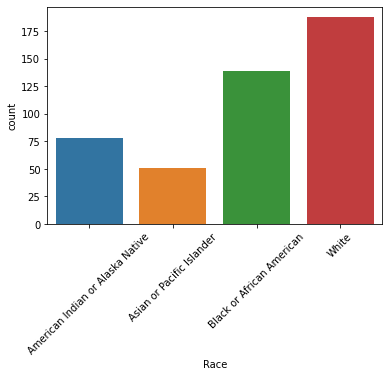

In [58]:
print(f"The race of the individuals who were victims of firearm related injuries is as follows:")
race = sns.countplot("Race", data = queried_wonder_data)
race.set_xticklabels(race.get_xticklabels(), rotation = 45)
None

The type of death of individuals who were victims of firearm related injuries is as follows:


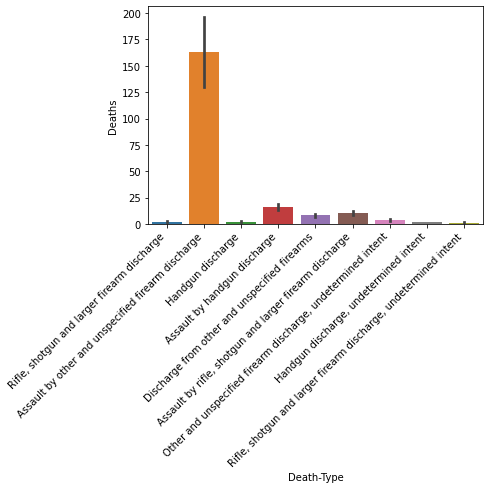

In [59]:
print(f"The type of death of individuals who were victims of firearm related injuries is as follows:")
death_type = sns.barplot(x = "Death-Type", y = "Deaths", data = queried_wonder_data)
death_type.set_xticklabels(death_type.get_xticklabels(), rotation = 45, horizontalalignment='right')
None

The # of deaths of individuals who were victims of firearm related injuries is as follows:


/var/folders/nm/bsmlffqn33l3l7dzkpk7xjym0000gn/T/ipykernel_86421/3492219309.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  deaths.set_xticklabels(deaths.get_xticklabels(), rotation = 45, horizontalalignment='right')


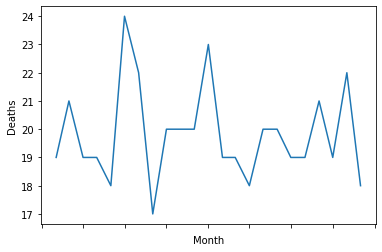

In [60]:
print(f"The # of deaths of individuals who were victims of firearm related injuries is as follows:")
queried_wonder_data_grouped = queried_wonder_data.groupby(['Month']).count()
deaths = sns.lineplot(x = "Month", y = "Deaths", data = queried_wonder_data_grouped)
deaths.set_xticklabels(deaths.get_xticklabels(), rotation = 45, horizontalalignment='right')
None

## References: 

- https://wonder.cdc.gov/wonder/help/WONDER-API.html
